In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_variance = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mean_vector = self.fc_mean(x)
        log_variance = self.fc_log_variance(x)
        return mean_vector, log_variance


In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=256, output_dim=784):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, latent_vector):
        latent_vector = torch.relu(self.fc1(latent_vector))
        latent_vector = torch.sigmoid(self.fc2(latent_vector))
        return latent_vector

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mean_vector, log_variance):
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        return mean_vector + eps * std

    def forward(self, x):
        mean_vector, log_variance = self.encoder(x)
        latent_vector = self.reparameterize(mean_vector, log_variance)
        reconstructed_image = self.decoder(latent_vector)
        return reconstructed_image, mean_vector, log_variance

In [21]:
def loss_function(reconstructed_image, original_image, mean_vector, log_variance, beta=0.1):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_image, original_image, reduction='sum') / original_image.size(0)
    kl_divergence = -0.5 * torch.sum(1 + log_variance - mean_vector.pow(2) - log_variance.exp()) / original_image.size(0)
    return reconstruction_loss + beta * kl_divergence


In [7]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.00MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
variational_autoencoder = VAE().to(device)
adam_optimizer = optim.Adam(variational_autoencoder.parameters(), lr=1e-3)

In [9]:
num_epochs = 20
variational_autoencoder.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_images, _ in data_loader:
        batch_images = batch_images.view(batch_images.size(0), -1).to(device)

        adam_optimizer.zero_grad()
        reconstructed_image, mean_vector, log_variance = variational_autoencoder(batch_images)
        loss = loss_function(reconstructed_image, batch_images, mean_vector, log_variance)
        loss.backward()
        adam_optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataset):.4f}")

Epoch [1/20], Loss: 1.4783
Epoch [2/20], Loss: 1.2893
Epoch [3/20], Loss: 1.2456
Epoch [4/20], Loss: 1.2239
Epoch [5/20], Loss: 1.2107
Epoch [6/20], Loss: 1.2012
Epoch [7/20], Loss: 1.1936
Epoch [8/20], Loss: 1.1866
Epoch [9/20], Loss: 1.1806
Epoch [10/20], Loss: 1.1744
Epoch [11/20], Loss: 1.1690
Epoch [12/20], Loss: 1.1642
Epoch [13/20], Loss: 1.1597
Epoch [14/20], Loss: 1.1556
Epoch [15/20], Loss: 1.1516
Epoch [16/20], Loss: 1.1475
Epoch [17/20], Loss: 1.1438
Epoch [18/20], Loss: 1.1401
Epoch [19/20], Loss: 1.1364
Epoch [20/20], Loss: 1.1332


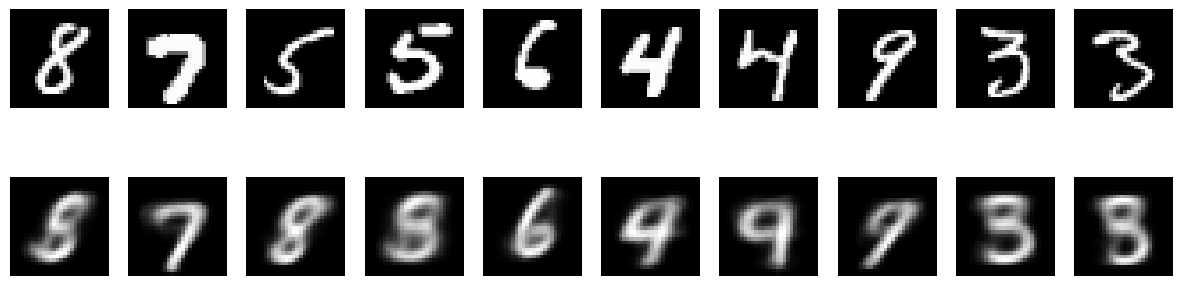

In [10]:
def plot_reconstructed_images(original_images, generated_images, num_images=10):
    original_images = original_images[:num_images].view(-1, 28, 28).cpu().detach().numpy()
    generated_images = generated_images[:num_images].view(-1, 28, 28).cpu().detach().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(generated_images[i], cmap='gray')
        axes[1, i].axis('off')
    plt.show()

variational_autoencoder.eval()
test_images, _ = next(iter(data_loader))
test_images = test_images.view(test_images.size(0), -1).to(device)
with torch.no_grad():
    reconstructed_images, _, _ = variational_autoencoder(test_images)

plot_reconstructed_images(test_images, reconstructed_images)


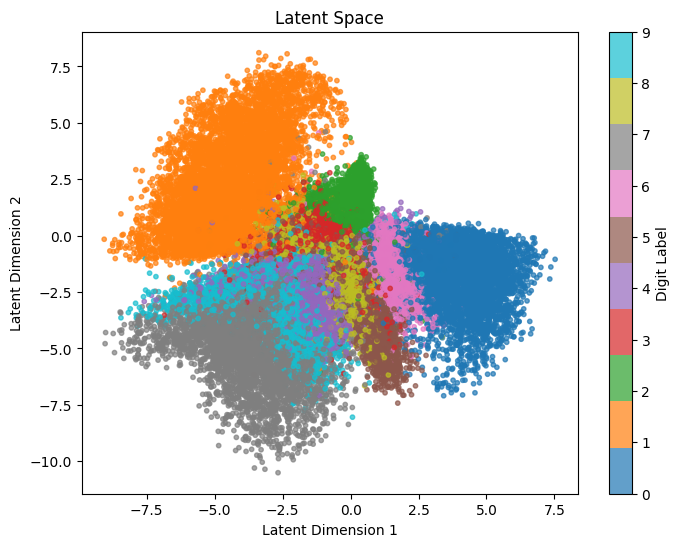

In [11]:
def plot_latent_space(variational_autoencoder, data_loader):
    variational_autoencoder.eval()
    latent_vectors, labels_list = [], []

    with torch.no_grad():
        for batch_images, labels in data_loader:
            batch_images = batch_images.view(batch_images.size(0), -1).to(device)
            mean_vector, log_variance = variational_autoencoder.encoder(batch_images)
            latent_vector = variational_autoencoder.reparameterize(mean_vector, log_variance)
            latent_vectors.append(latent_vector.cpu())
            labels_list.append(labels)

    latent_vectors = torch.cat(latent_vectors)
    labels = torch.cat(labels_list)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space")
    plt.show()

plot_latent_space(variational_autoencoder, data_loader)

In [12]:
def train_vae(latent_dim, num_epochs=20):
    variational_autoencoder = VAE(latent_dim=latent_dim).to(device)
    adam_optimizer = optim.Adam(variational_autoencoder.parameters(), lr=1e-3)
    variational_autoencoder.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_images, _ in data_loader:
            batch_images = batch_images.view(batch_images.size(0), -1).to(device)

            adam_optimizer.zero_grad()
            reconstructed_image, mean_vector, log_variance = variational_autoencoder(batch_images)
            loss = loss_function(reconstructed_image, batch_images, mean_vector, log_variance)
            loss.backward()
            adam_optimizer.step()

            epoch_loss += loss.item()

        print(f"Latent Dim: {latent_dim}, Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataset):.4f}")

    return variational_autoencoder

In [13]:
latent_dims = [2, 4, 16]
models = {}
for dim in latent_dims:
    print(f"\nTraining VAE with latent dimension: {dim}")
    models[dim] = train_vae(latent_dim=dim)


Training VAE with latent dimension: 2
Latent Dim: 2, Epoch [1/20], Loss: 1.4748
Latent Dim: 2, Epoch [2/20], Loss: 1.2958
Latent Dim: 2, Epoch [3/20], Loss: 1.2575
Latent Dim: 2, Epoch [4/20], Loss: 1.2345
Latent Dim: 2, Epoch [5/20], Loss: 1.2188
Latent Dim: 2, Epoch [6/20], Loss: 1.2067
Latent Dim: 2, Epoch [7/20], Loss: 1.1969
Latent Dim: 2, Epoch [8/20], Loss: 1.1884
Latent Dim: 2, Epoch [9/20], Loss: 1.1808
Latent Dim: 2, Epoch [10/20], Loss: 1.1742
Latent Dim: 2, Epoch [11/20], Loss: 1.1686
Latent Dim: 2, Epoch [12/20], Loss: 1.1635
Latent Dim: 2, Epoch [13/20], Loss: 1.1587
Latent Dim: 2, Epoch [14/20], Loss: 1.1548
Latent Dim: 2, Epoch [15/20], Loss: 1.1510
Latent Dim: 2, Epoch [16/20], Loss: 1.1478
Latent Dim: 2, Epoch [17/20], Loss: 1.1447
Latent Dim: 2, Epoch [18/20], Loss: 1.1419
Latent Dim: 2, Epoch [19/20], Loss: 1.1389
Latent Dim: 2, Epoch [20/20], Loss: 1.1363

Training VAE with latent dimension: 4
Latent Dim: 4, Epoch [1/20], Loss: 1.3538
Latent Dim: 4, Epoch [2/20], 

In [23]:
def compare_reconstructions(models, test_images):
    plt.figure(figsize=(18, 6))
    num_images = 10
    test_images = test_images[:num_images].to(device)
    test_images_flat = test_images.view(-1, 784)

    for i, (latent_dim, model) in enumerate(models.items()):
        model.eval()
        with torch.no_grad():
            reconstructed_images, _, _ = model(test_images_flat)
            reconstructed_images = reconstructed_images.view(-1, 28, 28).cpu().detach().numpy()

        for j in range(num_images):
            plt.subplot(len(models), num_images, i * num_images + j + 1)
            plt.imshow(reconstructed_images[j], cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.ylabel(f"Latent Dim: {latent_dim}", fontsize=12)

    plt.suptitle("Comparison of Reconstructions", fontsize=16)
    plt.show()


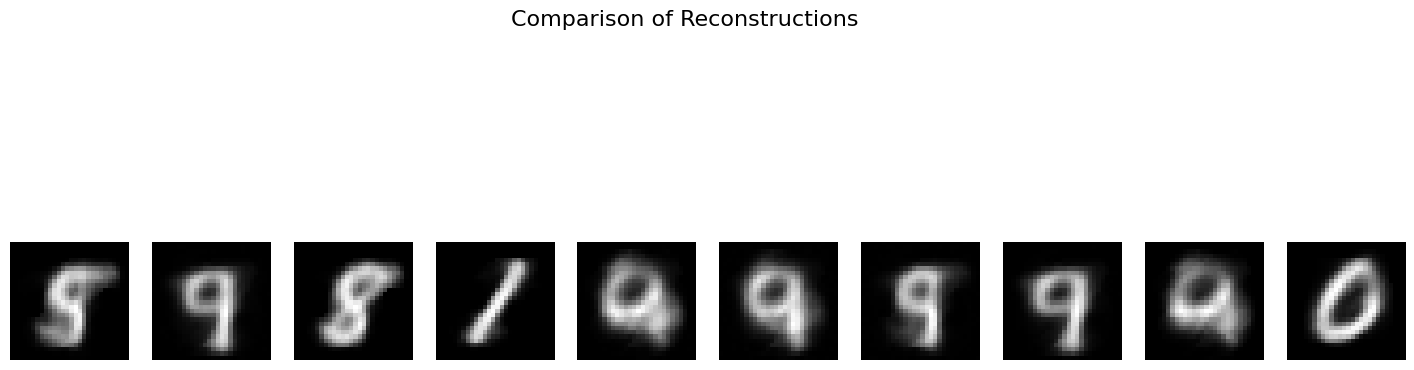

In [24]:
test_images, _ = next(iter(data_loader))
compare_reconstructions(models, test_images)



Visualizing latent space with T-SNE for latent dimension: 4


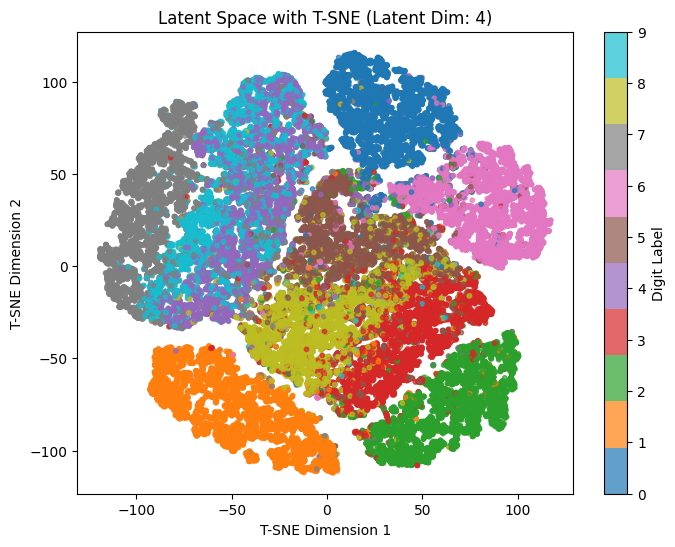


Visualizing latent space with T-SNE for latent dimension: 16


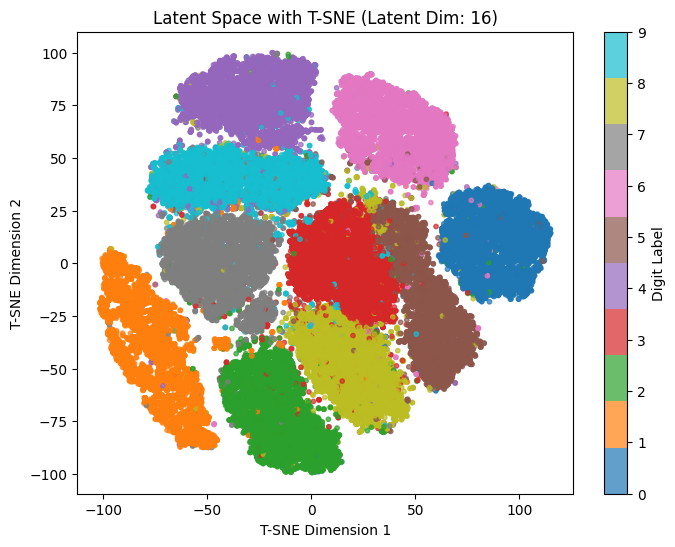

In [15]:


def plot_latent_space_with_tsne(model, data_loader, latent_dim):
    model.eval()
    latent_vectors, labels_list = [], []

    with torch.no_grad():
        for batch_images, labels in data_loader:
            batch_images = batch_images.view(batch_images.size(0), -1).to(device)
            mean_vector, log_variance = model.encoder(batch_images)
            latent_vector = model.reparameterize(mean_vector, log_variance)
            latent_vectors.append(latent_vector.cpu())
            labels_list.append(labels)

    latent_vectors = torch.cat(latent_vectors)
    labels = torch.cat(labels_list)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_latent = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_latent[:, 0], tsne_latent[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel("T-SNE Dimension 1")
    plt.ylabel("T-SNE Dimension 2")
    plt.title(f"Latent Space with T-SNE (Latent Dim: {latent_dim})")
    plt.show()

for dim in [4, 16]:
    print(f"\nVisualizing latent space with T-SNE for latent dimension: {dim}")
    plot_latent_space_with_tsne(models[dim], data_loader, latent_dim=dim)